In [ ]:
# load libs 

import pickle
import os
import csv
import numpy as np
import random
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import re

from dinov2_ood_utilities.imagenet_tree import ImagenetSemanticInfo


In [4]:
# objects of general use

imagenet_info = ImagenetSemanticInfo()
embed_dims = 384

Stop node discovered


In [5]:
# define paths to load

root_path = '/home/stud/afroehli/coding/model_results/dinov2_vits14/'

inet_1k_val_path = (root_path + 'inet_1k_val_timm_trans.pkl', 'inet_1k_val')
inet_v2_70_path = (root_path + 'inet_v2_70_timm_trans.pkl', 'inet_v2_70')
inet_v2_mf_path = (root_path + 'inet_v2_mf_timm_trans.pkl', 'inet_v2_mf')
inet_v2_top_path = (root_path + 'inet_v2_top_timm_trans.pkl', 'inet_v2_top')
inet_r_path = (root_path + 'inet_r_plus_pt_timm_trans.pkl', 'inet_r')

loading_paths = [inet_1k_val_path, inet_v2_70_path, inet_v2_mf_path, inet_v2_top_path, inet_r_path]

inet_c_basepath = root_path + 'imagenet_c'
inet_c_corruptions = os.listdir(inet_c_basepath)


In [6]:
# return dict only with cls-token from dict that holds pt-tokens + cls-token 

def cls_tokens_from_cls_plus_pt_tokens(cls_plus_pt_tokens: dict) -> dict:
    just_cls_tokens = dict()
    for class_wnid in cls_plus_pt_tokens.keys():
        just_cls_tokens[class_wnid] = [np.squeeze(cls_plus_pt[3][1]) for cls_plus_pt in cls_plus_pt_tokens[class_wnid]]

    return just_cls_tokens 

def get_cls_token_single_layer(cls_plus_pt_token: dict) -> dict: 
    just_cls_token = dict()
    for class_wnid in cls_plus_pt_token.keys():
        just_cls_token[class_wnid] = [np.squeeze(cls_plus_pt[1]) for cls_plus_pt in cls_plus_pt_token[class_wnid]]
    return just_cls_token


In [7]:
# load pre-computed embeddings 

model_results = dict()

# first all simple datasets
for load_path, dict_name in loading_paths:
    with open(load_path, 'rb') as pkl_file:
        if dict_name == 'inet_r':
            model_results[dict_name] = cls_tokens_from_cls_plus_pt_tokens(pickle.load(pkl_file))
        else:
            model_results[dict_name] = pickle.load(pkl_file)


# then all variations of imagenet-c
model_results['inet_c'] = dict()
for corruption in inet_c_corruptions:
    for sev_n in range(1, 6):
        if sev_n == 1: 
            model_results['inet_c'][corruption] = dict()

        with open(f'{inet_c_basepath}/{corruption}/sev_{sev_n}.pkl', 'rb') as pkl_file:
            inet_c_results_dict = pickle.load(pkl_file)
            wnid_list = list(inet_c_results_dict.keys())
            model_results['inet_c'][corruption][sev_n] = get_cls_token_single_layer(inet_c_results_dict)
            
            assert len(model_results['inet_c'][corruption][sev_n]) == len(wnid_list)
            for wnid in wnid_list:
                assert len(model_results['inet_c'][corruption][sev_n][wnid]) == 50 

    

In [8]:
def calc_l1_dist(emb_one: np.array, emb_two: np.array) -> float :
    return np.sum(np.abs(emb_one - emb_two))

def calc_c1_measure_res(emb_fixed: np.array, emb_class: np.array, emb_comp: np.array) -> float: 
    return (np.abs(emb_class - emb_fixed) < np.abs(emb_comp - emb_fixed)).tolist().count(True) 

def calc_c2_measure_res(emb_fixed_mean: np.array, emb_fixed_stddev: np.array, emb_class: np.array) -> float:
    return (np.abs(emb_fixed_mean - emb_class) <= emb_fixed_stddev).tolist().count(True) 

def calc_c3_measure_res(emb_fixed_mean: np.array, emb_fixed_stddev: np.array, emb_class_in: np.array, emb_class_out: np.array) -> float:
    abs_dist_in = np.abs(emb_class_in - emb_fixed_mean)
    abs_dist_out = np.abs(emb_class_out - emb_fixed_mean)
    return np.logical_and((abs_dist_in <= emb_fixed_stddev), (abs_dist_out >= emb_fixed_stddev)).tolist().count(True)

In [9]:
# for each of the used 4 distance measures, calculate distance of mean embedding of each remaining id-class to class-a embedding 

class_a_wnids = set(model_results['inet_r'].keys()) 

inet_1k_val_stats = dict()
inet_1k_wnids = set(model_results['inet_1k_val'].keys())

class_a_distances = {'l1_dist': dict(), 'count_dims_nearer': dict(), 'count_within_stddev': dict(), 'count_excl_within_stddev': dict()}

for wnid in inet_1k_wnids:
    inet_1k_val_stats[wnid] = dict()
    inet_1k_val_stats[wnid]['mean'] = np.mean(np.array(model_results['inet_1k_val'][wnid]), axis=0)
    inet_1k_val_stats[wnid]['stddev'] = np.std(np.array(model_results['inet_1k_val'][wnid]), axis=0)

# mean embedding of all ImageNet-1k samples
inet_1k_all_embeds = []
for wnid in model_results['inet_1k_val'].keys():
    inet_1k_all_embeds.extend(model_results['inet_1k_val'][wnid])
inet_1k_mean = np.mean(np.array(inet_1k_all_embeds), axis = 0)

# for each common wnid, calculate distance to remaining 999 wnids
for class_a in class_a_wnids:

    inet_1k_wnids.remove(class_a)

    for wnid in inet_1k_wnids:
        l1_dist = calc_l1_dist(inet_1k_val_stats[class_a]['mean'], inet_1k_val_stats[wnid]['mean'])
        counts_dims_nearer = calc_c1_measure_res(inet_1k_val_stats[class_a]['mean'], inet_1k_val_stats[wnid]['mean'], inet_1k_mean)
        within_stddev = calc_c2_measure_res(inet_1k_val_stats[class_a]['mean'], inet_1k_val_stats[class_a]['stddev'], 
                                                 inet_1k_val_stats[wnid]['mean'])
        excl_within_stddev = calc_c3_measure_res(inet_1k_val_stats[class_a]['mean'], inet_1k_val_stats[class_a]['stddev'], 
                                                                inet_1k_val_stats[wnid]['mean'], inet_1k_mean)

        try: 
            class_a_distances['l1_dist'][class_a].append((wnid, l1_dist))
            class_a_distances['count_dims_nearer'][class_a].append((wnid, counts_dims_nearer))
            class_a_distances['count_within_stddev'][class_a].append((wnid, within_stddev))
            class_a_distances['count_excl_within_stddev'][class_a].append((wnid, excl_within_stddev))
        except KeyError:
            class_a_distances['l1_dist'][class_a] = [(wnid, l1_dist)]
            class_a_distances['count_dims_nearer'][class_a] = [(wnid, counts_dims_nearer)]
            class_a_distances['count_within_stddev'][class_a] = [(wnid, within_stddev)]
            class_a_distances['count_excl_within_stddev'][class_a] = [(wnid, excl_within_stddev)]

    class_a_distances['l1_dist'][class_a].sort(key = lambda la: la[1])
    class_a_distances['count_dims_nearer'][class_a].sort(key = lambda la: la[1], reverse=True)
    class_a_distances['count_within_stddev'][class_a].sort(key = lambda la: la[1], reverse=True)
    class_a_distances['count_excl_within_stddev'][class_a].sort(key = lambda la: la[1], reverse=True)
    inet_1k_wnids.add(class_a)


In [ ]:
# store dict with all distances to class-a 

with open('../resources/class_a_distances.pkl', 'wb') as pkl_fl: 
    pickle.dump(class_a_distances, pkl_fl, pickle.HIGHEST_PROTOCOL)

# for each class-a store nearest class-b according to: l1-dist, count-dims-nearest, within_stddev, within-excl-stddev 
with open('../resources/class_a_classes_b.csv', 'w', newline='') as nearest_classes_table: 
    csv_writer = csv.writer(nearest_classes_table, delimiter=';')
    csv_writer.writerow(['Class-A', 'Class-B-L1', 'Class-B-C1', 'Class-B-C2', 'Class-B-C3'])

    for class_a_wnid in class_a_wnids:
        class_b_l1 = class_a_distances['l1_dist'][class_a_wnid][0][0]
        class_b_count_dims_nearer = class_a_distances['count_dims_nearer'][class_a_wnid][0][0]
        class_b_count_within_stddev = class_a_distances['count_within_stddev'][class_a_wnid][0][0]
        class_b_count_excl_within_stddev = class_a_distances['count_excl_within_stddev'][class_a_wnid][0][0]

        csv_writer.writerow([class_a_wnid, class_b_l1, class_b_count_dims_nearer, class_b_count_within_stddev, class_b_count_excl_within_stddev])


In [ ]:
# load mapping of class-a to list of classes-b

class_a_to_class_b_mapping = dict()

with open('../resources/class_a_classes_b.csv', 'r') as nearest_classes_table:
    class_mapping = csv.reader(nearest_classes_table, delimiter=';')

    skip_heading = True 
    for class_a_b_mapping in class_mapping:
        if skip_heading:
            skip_heading = False 
        else: 
            class_a = class_a_b_mapping[0]
            classes_b = [class_a_b_mapping[n] for n in range(1, 5)]
            class_a_to_class_b_mapping[class_a] = classes_b 


In [ ]:
# write explict class-names of [class-A; [classes-B]] in csv-file 

with open('../results/class_a_classes_b_inet_names_new.csv', 'w', newline='') as nearest_classes_table: 
    csv_writer = csv.writer(nearest_classes_table, delimiter=';')
    csv_writer.writerow(['Class-A', 'Class-B-L1', 'Class-B-dims-nearer', 'Class-B-within-stddev', 'Class-B-excl-within-stddev'])
    for class_a_wnid in class_a_to_class_b_mapping.keys():
        class_names = [imagenet_info.wnid_to_classname[class_a_wnid]]
        class_names.extend([imagenet_info.wnid_to_classname[class_b_wnid] for class_b_wnid in class_a_to_class_b_mapping[class_a_wnid]])
        csv_writer.writerow(class_names)

In [33]:
# common selections of class-b among 4 different measures 

# for each list with 4 different class-b instantiations
# choose pairs of two: 3 x 2 x 1 = 6 pairs, (1, 2), (1,3), (1, 4), (2, 3), (2,4), (3,4)  
# only increment when values for x and y in (x, y) are different 

comp_pairs = {(0, 1): 0, (0, 2): 0, (0, 3): 0, (1, 2): 0, (1, 3): 0, (2, 3): 0} 
for class_a_wnid in class_a_to_class_b_mapping.keys():
    classes_b = class_a_to_class_b_mapping[class_a_wnid]
    for pair_pos in comp_pairs.keys():
        if classes_b[pair_pos[0]] != classes_b[pair_pos[1]]:
            comp_pairs[pair_pos] += 1 

print(comp_pairs)

{(0, 1): 23, (0, 2): 32, (0, 3): 69, (1, 2): 39, (1, 3): 75, (2, 3): 69}


In [34]:
pat_first = re.compile('i.*not.*')
pat_second = re.compile('not.*and.*')
pat_both = re.compile('i.*and.*')
pat_none = re.compile('not.*not.*')

def calculate_in_stddev_stats(class_X_mean: np.array, store_dict: dict, class_a_mean, class_a_stddev, inet_1k_mean):

        inet_1k_class_a_dist = np.abs(inet_1k_mean - class_a_mean)
        class_X_class_a_dist = np.abs(class_X_mean - class_a_mean)

        for log_case in ['in_not_inet_mean', 'in_and_inet_mean', 'not_in_and_inet_mean', 'not_in_not_inet_mean']:


            if pat_first.fullmatch(log_case):
                store_dict[log_case] = np.logical_and((class_X_class_a_dist <= class_a_stddev), 
                                                                            (inet_1k_class_a_dist > class_a_stddev)).tolist().count(True)
            elif pat_second.fullmatch(log_case):
                store_dict[log_case] = np.logical_and((class_X_class_a_dist > class_a_stddev), 
                                                                (inet_1k_class_a_dist <= class_a_stddev)).tolist().count(True)
            elif pat_both.fullmatch(log_case):
                store_dict[log_case] = np.logical_and((class_X_class_a_dist <= class_a_stddev), 
                                                                (inet_1k_class_a_dist <= class_a_stddev)).tolist().count(True)
            elif pat_none.fullmatch(log_case):
                store_dict[log_case] = np.logical_and((class_X_class_a_dist > class_a_stddev), 
                                                                (inet_1k_class_a_dist > class_a_stddev)).tolist().count(True)
            else:
                raise ValueError(f'Logical case *{log_case}* was not matched')

In [ ]:
## calculate statistics 

# fixed order of inet-wnids
inet_wnids_static = []

with open('../resources/imagenet_train_class_to_index_mapping.csv', 'r') as class_index_table:
    class_index_reader = csv.reader(class_index_table, delimiter=';')
    for inet_class, _ in class_index_reader: 
        inet_wnids_static.append(inet_class)

stats_dict = dict()
random.seed(7)

# generate tuples of inet-wnids to compare 
compare_sets = []
for class_a in class_a_to_class_b_mapping.keys():
    classes_b = class_a_to_class_b_mapping[class_a]

    rand_wnid = inet_wnids_static[random.randrange(0, len(inet_wnids_static))]
    while rand_wnid == class_a or rand_wnid in classes_b:
        rand_wnid = inet_wnids_static[random.randrange(0, len(inet_wnids_static))]

    compare_sets.append((class_a, classes_b, rand_wnid))

# whole imagenet-1k statistics
inet_1k_all_embeds = []
for wnid in inet_wnids_static:
    inet_1k_all_embeds.extend(model_results['inet_1k_val'][wnid])

inet_1k_mean = np.mean(np.array(inet_1k_all_embeds), axis = 0)

class_b_measures = ['l1_dist', 'count_dims_nearer', 'count_in_stddev', 'count_excl_in_stddev']

# over all class pairs: classA, classB, classRandom
for class_a, classes_b, class_rand in compare_sets:

    comb_key = (class_a, tuple(classes_b), class_rand)
    stats_dict[comb_key] = {'dim_nearer': {'inet_c': dict()}, 'l1_dist': {'inet_c': dict()}, 'dim_std': {'inet_c': dict()}}

    class_a_mean = np.mean(np.array(model_results['inet_1k_val'][class_a]), axis=0)
    class_a_stddev = np.std(np.array(model_results['inet_1k_val'][class_a]), axis=0)
    class_r_mean = np.mean(np.array(model_results['inet_1k_val'][class_rand]), axis=0)

    classes_b_means = dict() 
    for measure, class_b in zip(class_b_measures, classes_b):
        classes_b_means[measure] = np.mean(np.array(model_results['inet_1k_val'][class_b]), axis=0)
    

    # measurement 1: dims nearer than inet-mean
    stats_dict[comb_key]['dim_nearer']['class_b'] = dict()
    for measure in classes_b_means.keys():
        class_b_mean = classes_b_means[measure]
        stats_dict[comb_key]['dim_nearer']['class_b'][measure] = (np.abs(class_b_mean - class_a_mean) < np.abs(inet_1k_mean - class_a_mean)).tolist().count(True)
    stats_dict[comb_key]['dim_nearer']['class_r'] = (np.abs(class_r_mean - class_a_mean) < np.abs(inet_1k_mean - class_a_mean)).tolist().count(True)

    # measurement 2: l1-distance
    stats_dict[comb_key]['l1_dist']['inet_mean'] = np.sum(np.abs(inet_1k_mean - class_a_mean))
    stats_dict[comb_key]['l1_dist']['class_b'] = dict()
    for measure in classes_b_means.keys():
        class_b_mean = classes_b_means[measure]
        stats_dict[comb_key]['l1_dist']['class_b'][measure] = np.sum(np.abs(class_b_mean - class_a_mean))
    stats_dict[comb_key]['l1_dist']['class_r'] = np.sum(np.abs(class_r_mean - class_a_mean))

    # measurement 3: dims in std-dev of class-a
    stats_dict[comb_key]['dim_std']['class_b'] = dict()
    for measure in class_b_measures:
        stats_dict[comb_key]['dim_std']['class_b'][measure] = dict()
        class_mean = classes_b_means[measure]
        calculate_in_stddev_stats(class_mean, stats_dict[comb_key]['dim_std']['class_b'][measure], 
                                  class_a_mean, class_a_stddev, inet_1k_mean)
        
    stats_dict[comb_key]['dim_std']['class_r'] = dict()
    calculate_in_stddev_stats(class_r_mean, stats_dict[comb_key]['dim_std']['class_r'], 
                                class_a_mean, class_a_stddev, inet_1k_mean)

   
    for res_key in ['inet_v2_70', 'inet_v2_mf', 'inet_v2_top', 'inet_r']:

        if res_key == 'inet_r_orig':
            pass 
        
        class_var_mean = np.mean(np.array(model_results[res_key][class_a]), axis=0)

        stats_dict[comb_key]['dim_nearer'][res_key] = (np.abs(class_var_mean - class_a_mean) < np.abs(inet_1k_mean - class_a_mean)).tolist().count(True)
        stats_dict[comb_key]['l1_dist'][res_key] = np.sum(np.abs(class_var_mean - class_a_mean))
        stats_dict[comb_key]['dim_std'][res_key] = dict()
        calculate_in_stddev_stats(class_var_mean, stats_dict[comb_key]['dim_std'][res_key], class_a_mean, class_a_stddev, inet_1k_mean)

    # stats for 15 corruptions a' 5 severity levels
    for cor in inet_c_corruptions: 
        for sev in range(1, 6):

            if sev == 1:
                stats_dict[comb_key]['dim_nearer']['inet_c'][cor] = dict()
                stats_dict[comb_key]['l1_dist']['inet_c'][cor] = dict()
                stats_dict[comb_key]['dim_std']['inet_c'][cor] = dict()

            inet_c_class_mean = np.mean(np.array(model_results['inet_c'][cor][sev][class_a]), axis=0)

            stats_dict[comb_key]['dim_nearer']['inet_c'][cor][f'sev_{sev}'] = (np.abs(inet_c_class_mean - class_a_mean) < np.abs(inet_1k_mean - class_a_mean)).tolist().count(True)
            stats_dict[comb_key]['l1_dist']['inet_c'][cor][f'sev_{sev}'] = np.sum(np.abs(inet_c_class_mean - class_a_mean))
            stats_dict[comb_key]['dim_std']['inet_c'][cor][f'sev_{sev}'] = dict()
            calculate_in_stddev_stats(inet_c_class_mean, stats_dict[comb_key]['dim_std']['inet_c'][cor][f'sev_{sev}'], 
                                      class_a_mean, class_a_stddev, inet_1k_mean)


In [ ]:
# store all comparison sequences in file
# write csv file: class-a, class-b-l1, class-b-c1, class-b-c2, class-b-c3, class-r

with open('../results/complete_comp_sequences_names_new.csv', 'w', newline='') as csv_fl:
    csv_writer = csv.writer(csv_fl, delimiter=';')

    csv_writer.writerow(['Class-A', 'Class-B-L1', 'Class-B-C1', 'Class-B-C2', 'Class-B-C3', 'Class-R'])
    for class_a, classes_b, class_r in stats_dict.keys():
        next_seq = [class_a]
        next_seq.extend(classes_b)
        next_seq.append(class_r)
        next_seq_names = [imagenet_info.wnid_to_classname[wnid] for wnid in next_seq]
        csv_writer.writerow(next_seq_names)


In [ ]:
# ----- DataFrage for ImageNnet-C results ----- #

# df_inet_c_data: DataFrame holding all results for Imagenet-C dataset

def get_corruption_type(cor_name: str) -> str:
    if cor_name in ['gaussian_noise', 'shot_noise', 'impulse_noise', 'speckle_noise']:
        return 'noise'
    elif cor_name in ['defocus_blur', 'glass_blur', 'motion_blur', 'zoom_blur', 'gaussian_blur']:
        return 'blur'
    elif cor_name in ['snow', 'frost', 'brightness', 'fog', 'spatter']:
        return 'weather'
    elif cor_name in ['contrast', 'elastic_transform', 'pixelate', 'jpeg_compression', 'saturate']:
        return 'digital'
    else:
        return 'missing'
    

df_inet_c_data = []
for comb in stats_dict.keys():
    for cor in stats_dict[comb]['dim_nearer']['inet_c'].keys():
        for sev in stats_dict[comb]['dim_nearer']['inet_c'][cor].keys():
            df_inet_c_data.append((stats_dict[comb]['dim_nearer']['inet_c'][cor][sev],
                                   stats_dict[comb]['l1_dist']['inet_c'][cor][sev],
                                   stats_dict[comb_key]['dim_std']['inet_c'][cor][sev]['in_not_inet_mean'],
                                   stats_dict[comb_key]['dim_std']['inet_c'][cor][sev]['in_and_inet_mean'],
                                   stats_dict[comb_key]['dim_std']['inet_c'][cor][sev]['not_in_and_inet_mean'],
                                   stats_dict[comb_key]['dim_std']['inet_c'][cor][sev]['not_in_not_inet_mean'],
                                    cor, sev, 'A*'))
        
df_inet_c = pd.DataFrame(data=df_inet_c_data, columns=['dim_nearer', 'l1_dist', 'in_not_inet_mean', 'in_and_inet_mean',
                                                       'not_in_not_inet_mean', 'not_in_and_inet_mean', 'cor_name', 'severity', 'Split'])

# additional transformations on inet-c DataFrame
df_inet_c = df_inet_c.assign(cor_type = lambda x : pd.Series([get_corruption_type(row['cor_name']) for _, row in x.iterrows()]))
df_inet_c = df_inet_c.assign(dim_rel=lambda x: (x['dim_nearer'] / embed_dims) * 100)
# sort withing family of courruptions according to mean 
df_inet_c_grouped = df_inet_c.groupby('cor_name')['dim_rel'].mean().to_frame()
df_inet_c_grouped['cor_name'] = df_inet_c_grouped.index
ds_cor_mean = df_inet_c['cor_name'].apply(lambda x: df_inet_c_grouped[df_inet_c_grouped['cor_name'] == x]['dim_rel'].iloc[0])
df_inet_c['cor_mean'] = ds_cor_mean
df_inet_c = df_inet_c.sort_values(['cor_type', 'cor_mean'], ascending=False)
# get max/min values for each corruption method
group_max = df_inet_c.groupby(['cor_name'])['dim_rel'].max().to_frame()
group_min = df_inet_c.groupby(['cor_name'])['dim_rel'].min().to_frame()
group_max['cor_name'] = group_max.index 
group_min['cor_name'] = group_min.index 
y_min_per_cor = list(group_min['dim_rel'])
y_max_per_cor = list(group_max['dim_rel'])
x_cor_names = list(group_max['cor_name'])

group_l1_mean = df_inet_c.groupby(['cor_name', 'severity'])['l1_dist'].mean().to_dict()
group_dim_nearer_mean = df_inet_c.groupby(['cor_name', 'severity'])['dim_rel'].mean().to_dict()
l1_vals_per_sev_per_cor = {'sev_1': dict(), 'sev_2': dict(), 'sev_3': dict(), 'sev_4': dict(), 'sev_5': dict()}

for cor_type, sev in group_l1_mean.keys():
    l1_vals_per_sev_per_cor[sev][cor_type]= group_l1_mean[(cor_type, sev)]

c1_vals_per_sev_per_cor = {'sev_1': dict(), 'sev_2': dict(), 'sev_3': dict(), 'sev_4': dict(), 'sev_5': dict()}
for cor_type, sev in group_dim_nearer_mean.keys():
    c1_vals_per_sev_per_cor[sev][cor_type] = group_dim_nearer_mean[(cor_type, sev)]

x_data_l1_points = []
y_data_l1_points = []
data_l1_points = {'1': {'x_data': [], 'y_data': []}, '2': {'x_data': [], 'y_data': []}, '3': {'x_data': [], 'y_data': []}, 
                  '4': {'x_data': [], 'y_data': []}, '5': {'x_data': [], 'y_data': []}}

for sev in l1_vals_per_sev_per_cor.keys():
    sev_n = sev.split('_')[-1:][0]
    for cor in l1_vals_per_sev_per_cor[sev].keys():
        data_l1_points[sev_n]['x_data'].append(cor)
        data_l1_points[sev_n]['y_data'].append(l1_vals_per_sev_per_cor[sev][cor])

data_c1_points = {'1': {'x_data': [], 'y_data': []}, '2': {'x_data': [], 'y_data': []}, '3': {'x_data': [], 'y_data': []}, 
                  '4': {'x_data': [], 'y_data': []}, '5': {'x_data': [], 'y_data': []}}
for sev in c1_vals_per_sev_per_cor.keys():
    sev_n = sev.split('_')[-1:][0]
    for cor in c1_vals_per_sev_per_cor[sev].keys():
        data_c1_points[sev_n]['x_data'].append(cor)
        data_c1_points[sev_n]['y_data'].append(c1_vals_per_sev_per_cor[sev][cor])


In [40]:
# ----- DataFrame with all results ----- #


# df_basic_data: holds all results for used datasets other than Imagenet-C
class_b_measures = ['l1_dist', 'count_dims_nearer', 'count_in_stddev', 'count_excl_in_stddev']

dfs_basic = dict()
for class_b_measure in class_b_measures:
    df_basic_data = []
    for dset in ['class_b', 'class_r', 'inet_v2_70', 'inet_v2_mf', 'inet_v2_top', 'inet_r']:
        if dset == 'class_b':
            split = 'B'
        elif dset == 'class_r':
            split = 'Random'
        else:
            split = 'A*'
        
        if dset == 'class_b':
            df_basic_data.extend(list(
                        zip([stats_dict[comb]['dim_nearer'][f'{dset}'][class_b_measure] for comb in stats_dict.keys()], 
                            [stats_dict[comb]['l1_dist'][f'{dset}'][class_b_measure] for comb in stats_dict.keys()], 
                            [stats_dict[comb]['dim_std'][f'{dset}'][class_b_measure]['in_not_inet_mean'] for comb in stats_dict.keys()],
                            [stats_dict[comb]['dim_std'][f'{dset}'][class_b_measure]['in_and_inet_mean'] for comb in stats_dict.keys()],
                            [stats_dict[comb]['dim_std'][f'{dset}'][class_b_measure]['not_in_and_inet_mean'] for comb in stats_dict.keys()],
                            [stats_dict[comb]['dim_std'][f'{dset}'][class_b_measure]['not_in_not_inet_mean'] for comb in stats_dict.keys()],
                            [f'{dset}' for n in stats_dict.keys()],
                            [split for _ in stats_dict.keys()])
                    ))
        else:
            df_basic_data.extend(list(
                                    zip([stats_dict[comb]['dim_nearer'][f'{dset}'] for comb in stats_dict.keys()], 
                                        [stats_dict[comb]['l1_dist'][f'{dset}'] for comb in stats_dict.keys()], 
                                        [stats_dict[comb]['dim_std'][f'{dset}']['in_not_inet_mean'] for comb in stats_dict.keys()],
                                        [stats_dict[comb]['dim_std'][f'{dset}']['in_and_inet_mean'] for comb in stats_dict.keys()],
                                        [stats_dict[comb]['dim_std'][f'{dset}']['not_in_and_inet_mean'] for comb in stats_dict.keys()],
                                        [stats_dict[comb]['dim_std'][f'{dset}']['not_in_not_inet_mean'] for comb in stats_dict.keys()],
                                        [f'{dset}' for n in stats_dict.keys()],
                                        [split for _ in stats_dict.keys()])
                                ))
    dfs_basic[class_b_measure] = pd.DataFrame(data = df_basic_data, columns = ['dim_nearer', 'l1_dist', 'in_not_inet_mean', 'in_and_inet_mean', 
                                                            'not_in_and_inet_mean', 'not_in_not_inet_mean', 'dset', 'Split'])

    # add inet-c data to general DataFrame
    df_inet_c = df_inet_c.assign(dset= lambda x: 'inet_c_' + x['severity'])
    dfs_basic[class_b_measure] = pd.concat([dfs_basic[class_b_measure], df_inet_c[['dim_nearer', 'l1_dist', 'in_not_inet_mean', 'in_and_inet_mean',
                                                                    'not_in_not_inet_mean', 'not_in_and_inet_mean', 'dset', 'Split']]],
                                                                    ignore_index=True)
    
    # transformation of results to percentages
    dfs_basic[class_b_measure] = dfs_basic[class_b_measure].assign(dim_rel = lambda x: (x['dim_nearer'] / embed_dims) * 100)

# new DataFrame only for data about std-deviation
dfs_melted = dict()
for class_b_measures in ['count_in_stddev', 'count_excl_in_stddev']: 
    dfs_melted[class_b_measures] = pd.melt(dfs_basic[class_b_measures], id_vars=['dset', 'Split'], value_vars=['in_not_inet_mean', 'in_and_inet_mean', 'not_in_and_inet_mean', 'not_in_not_inet_mean'],
                        value_name='n_dims', var_name='split')
    dfs_melted[class_b_measures]['n_dims_rel'] = (dfs_melted[class_b_measures]['n_dims'] / embed_dims) * 100


# create DICT for plotting results of C2, and C3 measure

# get all C2 and C3 results from DF with data for class-B of C2 measure, and class-B of C3 measure
# two dictionaries, one for each measure
stddev_measures = ['count_in_stddev', 'count_excl_in_stddev']
# dict = {dset: {case_1: , case_2: , case_3: , case_4: }}
log_cases = ['in_not_inet_mean', 'in_and_inet_mean', 'not_in_and_inet_mean', 'not_in_not_inet_mean']
c2_c3_measure_results = dict()
# for dset in dfs_basic[class_b_measure]['dset'].unique():
for measure in stddev_measures:
    c2_c3_measure_results[measure] = dict()
    for log_case in log_cases:
        #print(dfs_basic[class_b_measure][['dset', log_case]].groupby('dset').mean().to_dict())
        c2_c3_measure_results[measure][log_case] = dfs_basic[measure][['dset', log_case]].groupby('dset').mean().to_dict()[log_case]


# create temporary list of x-labels aligning to general order of classes in diagrams
x_labels_stddev_tmp = dfs_basic['count_dims_nearer']['dset'].unique()
bar_per_log_case = dict()
for log_case in c2_c3_measure_results['count_excl_in_stddev'].keys():
    # first add result of class-B according to C2 measure
    bar_per_log_case[log_case] = [(c2_c3_measure_results['count_in_stddev'][log_case]['class_b'] / embed_dims) * 100]

    # add remaining results from DICT with C3-DF
    # guarantee strict order of selection of results 
    dset_name_list = dfs_basic['count_dims_nearer']['dset'].unique()
    for n, dset_name in enumerate(dset_name_list):
        bar_per_log_case[log_case].append((c2_c3_measure_results['count_excl_in_stddev'][log_case][dset_name] / embed_dims) * 100) 

# create final list of x-labels for stddev-plot
x_labels_stddev_plot = ['class_b_c2', 'class_b_c3']
x_labels_stddev_plot.extend(x_labels_stddev_tmp[1:])

# final DICT used for plotting, has only three logical cases 
stddev_results = {'only_class_x': bar_per_log_case['in_not_inet_mean'], 
                  'class_x_and_inet_mean': bar_per_log_case['in_and_inet_mean'], 
                  'not_class_x': [a + b for a, b in zip(bar_per_log_case['not_in_and_inet_mean'], bar_per_log_case['not_in_not_inet_mean'])]}

# # add inet-c data to general DataFrame
# df_basic = pd.concat([df_basic, df_inet_c.assign(dset='inet_c')[['dim_nearer', 'l1_dist', 'Split']]], ignore_index=True)

# calculate Imagenet-1k L1-Mean
ds_inet_mean_l1_dist = pd.Series([stats_dict[comb]['l1_dist']['inet_mean'] for comb in stats_dict.keys()])
inet_mean_l1_dist_mean = ds_inet_mean_l1_dist.mean()

In [ ]:
# create csv with all mean results per measure 
# 'dim_nearer', 'l1_dist', 'in_not_inet_mean', 'in_and_inet_mean',  

embed_dims = 384

df_l1 = dfs_basic['count_dims_nearer']
l1_val_avg = df_l1.groupby(['dset'])['l1_dist'].mean()
c1_val_avg = df_l1.groupby(['dset'])['dim_nearer'].mean()
both_within_stddev_val_avg = df_l1.groupby(['dset'])['in_and_inet_mean'].mean()
excl_within_stddev_val_avg = df_l1.groupby(['dset'])['in_not_inet_mean'].mean()

c2_c3_val_avg = pd.concat([both_within_stddev_val_avg, excl_within_stddev_val_avg], axis=1)
c2_c3_val_avg = c2_c3_val_avg.assign(c2= lambda x: x['in_and_inet_mean'] + x['in_not_inet_mean'])
c2_c3_val_avg = c2_c3_val_avg.assign(c3= lambda x: x['in_not_inet_mean'])
c2_c3_val_avg.drop(['in_and_inet_mean', 'in_not_inet_mean'], axis=1, inplace=True)
avg_measure_all = pd.concat([c2_c3_val_avg, c1_val_avg, l1_val_avg], axis=1)
avg_measure_all.drop(['class_b', 'class_r'], inplace=True)
avg_measure_all.rename({'dim_nearer': 'c1'}, axis=1, inplace=True)
avg_measure_all.index.name = 'dataset'

# normalize values for c1, c2, and c3 measure 

avg_measure_all['c1'] = avg_measure_all['c1'].apply(lambda x: x / embed_dims)
avg_measure_all['c2'] = avg_measure_all['c2'].apply(lambda x: x / embed_dims)
avg_measure_all['c3'] = avg_measure_all['c3'].apply(lambda x: x / embed_dims)



                    c2        c3        c1     l1_dist
dataset                                               
inet_c_sev_1  0.980674  0.237390  0.768167  193.948395
inet_c_sev_2  0.944079  0.227522  0.702090  261.079498
inet_c_sev_3  0.895011  0.209019  0.651534  318.191406
inet_c_sev_4  0.843476  0.187911  0.589387  390.724548
inet_c_sev_5  0.766447  0.158580  0.520074  478.026642
inet_r        0.807253  0.163854  0.559063  418.955475
inet_v2_70    0.977057  0.250560  0.716953  233.969543
inet_v2_mf    0.970885  0.247018  0.709674  243.640472
inet_v2_top   0.978945  0.252669  0.715417  234.731995


In [ ]:
# combine avg measure values with accuracy values of linear classifier 

map_dname = {'inet-c-sev-1': 'inet_c_sev_1', 'inet-c-sev-2': 'inet_c_sev_2', 'inet-c-sev-3': 'inet_c_sev_3', 'inet-c-sev-4': 'inet_c_sev_4',
             'inet-c-sev-5': 'inet_c_sev_5', 'inet_r': 'inet_r', 'inet_v2_70': 'inet_v2_70', 'inet_v2_mf': 'inet_v2_mf', ''
             'inet_v2_top': 'inet_v2_top'}

with open('../storage/ood_acc_results.csv', 'r', newline='') as csv_fl:
    ood_acc_df = pd.read_csv(csv_fl, sep=';')

ood_acc_df = ood_acc_df.loc[ood_acc_df['dataset'] != 'inet_1k_val']
ood_acc_df['dataset'] = ood_acc_df.apply(lambda x: map_dname[x['dataset']], axis=1)
ood_acc_df.set_index(ood_acc_df['dataset'], inplace=True)
ood_acc_df.drop('Unnamed: 0', axis='columns', inplace=True)

ood_acc_and_measures_df = pd.concat([ood_acc_df, avg_measure_all], axis=1)
ood_acc_and_measures_df.drop('dataset', axis=1, inplace=True)

with open('../storage/measures_and_ood_acc_results_normalized.csv', 'w', newline='') as csv_fl:
    ood_acc_and_measures_df.to_csv(csv_fl, sep=';')

ood_acc_and_measures_df['CLS'] = ood_acc_and_measures_df['cls-acc']
ood_acc_and_measures_df['Patch + CLS'] = ood_acc_and_measures_df['patch-acc']
ood_acc_and_measures_df.drop('patch-acc', axis=1, inplace=True)
ood_acc_and_measures_df.drop('cls-acc', axis=1, inplace=True)
ood_acc_and_measures_df.rename({ 'c2': 'C2 measure', 'c3': 'C3 Measure', 'c1': 'C1 Measure', 'l1_dist': 'L1 Measure'},
                               inplace=True, axis=1)
col_old = ood_acc_and_measures_df.columns
ood_acc_and_measures_df.set_index(pd.Index(['ImageNet-C-Sev-1', 'ImageNet-C-Sev-2', 'ImageNet-C-Sev-3', 'ImageNet-C-Sev-4', 'ImageNet-C-Sev-5',
                                            'ImageNet-R', 'ImageNet-V2-70', 'ImageNet-V2-MF', 'ImageNet-V2-TOP']), inplace=True)
ood_acc_and_measures_df.columns = pd.MultiIndex.from_tuples([
    ('Measure', col_old[0]),
    ('Measure', col_old[1]),
    ('Measure', col_old[2]),
    ('Measure', col_old[3]),
    ('Accuracy', col_old[4]), 
    ('Accuracy', col_old[5])])

with open('/home/stud/afroehli/coding/dinov2_ood/diagrams/ood_acc_and_measures.tex', 'w') as latex_table:

    ood_acc_and_measures_df.style.background_gradient(cmap='viridis').background_gradient(cmap='viridis_r', subset=[('Measure', 'L1 Measure')]).set_table_styles([
        {"selector": "th, td", "props": [("font-size", "20px"), ("padding", "12px")]},
        {'selector': 'th.col_heading.level0', 'props': [('text-align', 'center')]},
        {'selector': 'th.col_heading.level1', 'props': [('text-align', 'center')]},
        {
            'selector': 'th.col_heading.level1:2',
            'props': [('border-right', '4px solid black')]
        },
        {
            'selector': 'td:3',
            'props': [('border-right', '4px solid black')]
        }
    ]).to_latex(latex_table)

ood_acc_and_measures_df.style.background_gradient(cmap='viridis').background_gradient(cmap='viridis_r', subset=[('Measure', 'L1 Measure')]).set_table_styles([
        {"selector": "th, td", "props": [("font-size", "20px"), ("padding", "12px")]},
        {'selector': 'th.col_heading.level0', 'props': [('text-align', 'center')]},
        {'selector': 'th.col_heading.level1', 'props': [('text-align', 'center')]},
        {
            'selector': 'th.col_heading.level1:2',
            'props': [('border-right', '4px solid black')]
        },
        {
            'selector': 'td:3',
            'props': [('border-right', '4px solid black')]
        }
    ])


In [ ]:
# general settings for all plots #

new_x_labels = {'class_b_c2': 'INet-1k', 'class_b_c3': 'INet-1k', 'class_b': 'INet-1k', 'class_r': 'INet-1k', 'inet_v2_70': 'INet-V2-70', 'inet_v2_mf': 'INet-V2-MF',
'inet_v2_top': 'INet-V2-TOP', 'inet_r': 'INet-R', 'inet_c_sev_1': 'INet-C Sev. 1', 'inet_c_sev_2': 'INet-C Sev. 2', 
'inet_c_sev_3': 'INet-C Sev. 3', 'inet_c_sev_4': 'INet-C Sev. 4', 'inet_c_sev_5': 'INet-C Sev. 5'}

def x_labels_mapping(old_labels: list):
    for label_obj in old_labels:
        label_obj._text = new_x_labels[label_obj._text]

a_4_size = (11.7, 8.27)
a_5_size = (a_4_size[0]/2, a_4_size[1]/2)

save_dir = '../diagrams'

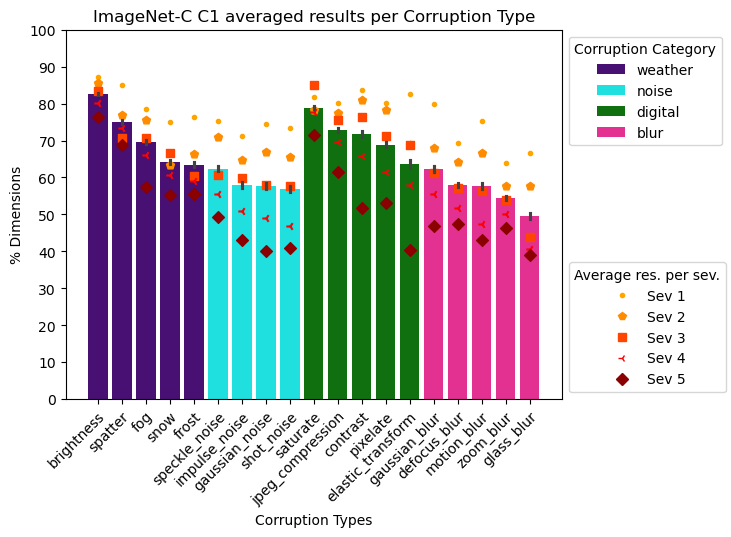

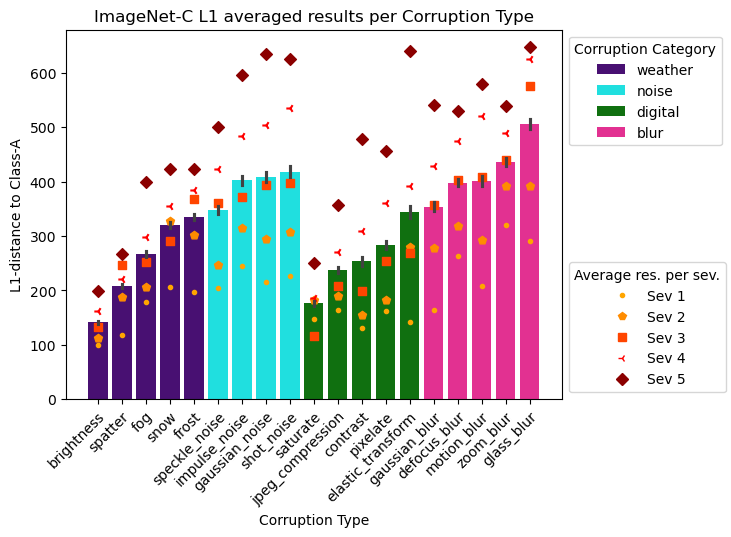

In [44]:
# --- only ImageNet-C plots --- # 

# INet-C plots
handles_sev = [Line2D([0], [0], label='manual point', marker='.', color='orange', linestyle=''),
               Line2D([0], [0], label='manual point', marker='p', color='darkorange', linestyle=''),
               Line2D([0], [0], label='manual point', marker='s', color='orangered', linestyle=''),
               Line2D([0], [0], label='manual point', marker='3', color='red', linestyle=''),
               Line2D([0], [0], label='manual point', marker='D', color='darkred', linestyle='')]
markers = [('.', 'orange'), ('p', 'darkorange'), ('s', 'orangered'), ('3', 'red'), ('D', 'darkred')]
palette=['indigo', 'cyan', 'green', 'deeppink']

# plot for ImageNet-C C1 results # 

sns_plot = sns.barplot(data=df_inet_c, x='cor_name', y='dim_rel', hue='cor_type', palette = palette)
sns_plot.set(xlabel='Corruption Types', ylabel='% Dimensions')
# add scatters per sev-result 
for n, sev in enumerate(data_c1_points.keys()):
    x_data_scatter = data_c1_points[sev]['x_data']
    y_data_scatter = data_c1_points[sev]['y_data']
    plt.scatter(x=x_data_scatter, y=y_data_scatter, marker=markers[n][0], color=markers[n][1])
# add legends
handles_bar, labels_bar = sns_plot.get_legend_handles_labels()
legend_sevs = sns_plot.legend(handles_sev, ['Sev 1', 'Sev 2', 'Sev 3', 'Sev 4', 'Sev 5'], 
                              bbox_to_anchor=(1,0), loc='lower left', title='Average res. per sev.')
sns_plot.add_artist(legend_sevs)
sns_plot.legend(handles_bar, labels_bar, bbox_to_anchor=(1,1), loc='upper left', title='Corruption Category')
# x-ticks
plt.xticks(rotation=45, rotation_mode='anchor', ha='right')
plt.title('ImageNet-C C1 averaged results per Corruption Type')
plt.ylim((0, 100))
sns_plot.set_yticks(np.arange(0, 101, 10))
plt.plot()
plt.savefig(f'{save_dir}/inet_c_dims_nearer.png', bbox_inches='tight')
plt.show()


# plot for ImageNet-C L1 results # 

sns_plot = sns.barplot(data=df_inet_c, x='cor_name', y='l1_dist', hue='cor_type', palette=palette)
sns_plot.set(xlabel='Corruption Type', ylabel='L1-distance to Class-A')
for n, sev in enumerate(data_l1_points.keys()):
    x_data_scatter = data_l1_points[sev]['x_data']
    y_data_scatter = data_l1_points[sev]['y_data']
    plt.scatter(x=x_data_scatter, y=y_data_scatter, marker=markers[n][0], color=markers[n][1])
handles_bars, leg_bars = sns_plot.get_legend_handles_labels()
legend_sevs = sns_plot.legend(handles_sev, ['Sev 1', 'Sev 2', 'Sev 3', 'Sev 4', 'Sev 5'], 
                              bbox_to_anchor=(1,0), loc='lower left', title='Average res. per sev.')
sns_plot.add_artist(legend_sevs)
sns_plot.legend(handles_bars, leg_bars, bbox_to_anchor=(1,1), loc='upper left', title='Corruption Category')
plt.xticks(rotation=45, rotation_mode='anchor', ha='right')
plt.title('ImageNet-C L1 averaged results per Corruption Type')
plt.plot()
plt.savefig(f'{save_dir}/inet_c_l1_dist.png', bbox_inches='tight')
plt.show()

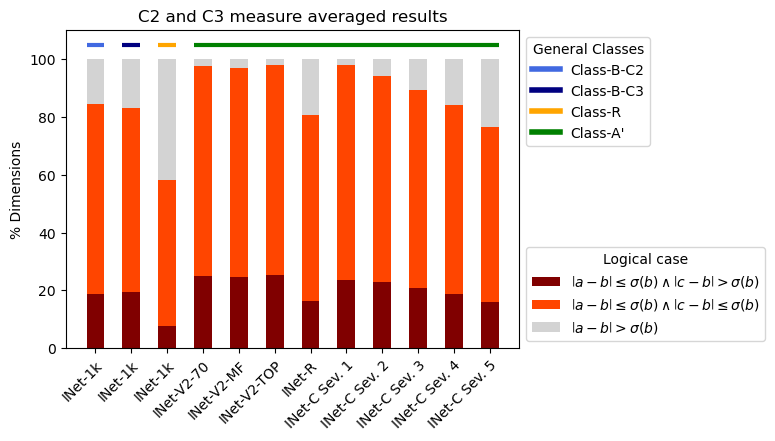

In [48]:
# --- overall C2-C3 measures results plot --- #

# stacked bar graphs for visualizing c2, c3 measures 
fig, ax = plt.subplots(figsize=a_5_size)
bottom_vals = np.zeros(len(x_labels_stddev_plot))
width = 0.5
for color, (log_case, weight_count) in zip(['maroon', 'orangered', 'lightgrey'], stddev_results.items()):
    p = ax.bar(x_labels_stddev_plot, weight_count, width, label=log_case, bottom=bottom_vals, color=color)
    bottom_vals += weight_count

ax.hlines(105, -0.25, 0.25, color='royalblue', linewidth=3)
ax.hlines(105, 0.75, 1.25, color='navy', linewidth=3)
ax.hlines(105, 1.75, 2.25, color='orange', linewidth=3)
ax.hlines(105, 2.75, 11.25, color='green', linewidth=3)
plt.xticks(rotation=45, rotation_mode='anchor', ha='right')
handles, legend = ax.get_legend_handles_labels()

handles_2 = [
    Line2D([0], [0], color='royalblue', lw=4, label='Class-B-C2'),
    Line2D([0], [0], color='navy', lw=4, label='Class-B-C3'),
    Line2D([0], [0], color='orange', lw=4, label='Class-R'),
    Line2D([0], [0], color='green', lw=4, label='Class-A\''),
]

leg_2 = ax.legend(handles_2, ['Class-B-C2', 'Class-B-C3', 'Class-R', 'Class-A\''], bbox_to_anchor=(1,1), loc='upper left', title='General Classes')
ax.add_artist(leg_2)
leg_1 = ax.legend(handles, [r'$\left| a - b \right| \leq \sigma(b) \wedge \left| c - b \right| > \sigma(b) $',
                            r'$\left| a - b \right| \leq \sigma(b) \wedge \left| c - b \right| \leq \sigma(b) $',
                            r'$\left| a - b \right| > \sigma(b)$'], bbox_to_anchor=(1,0), 
                            loc='lower left', title='Logical case')
ax.set_ylabel('% Dimensions')
plt.title('C2 and C3 measure averaged results')
loc, labels = plt.xticks()
x_labels_mapping(labels)
plt.xticks(loc, labels)
plt.savefig(f'{save_dir}/overall_c2_c3.png', bbox_inches='tight')
plt.show()

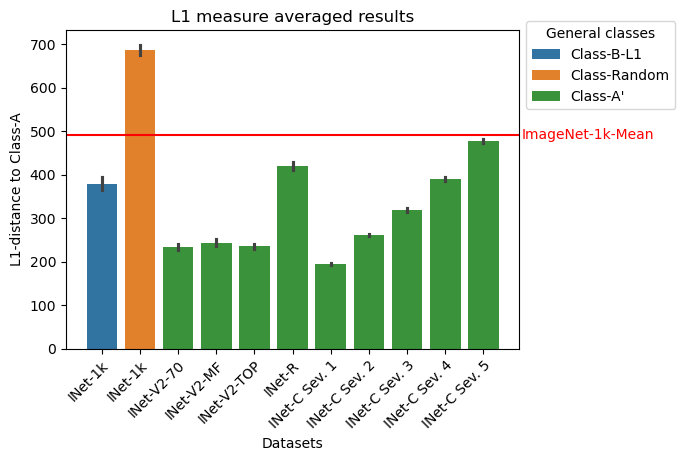

In [46]:
# --- overall L1 measure result plot --- # 

fig, ax = plt.subplots(figsize=a_5_size)
sns_plot = sns.barplot(ax=ax, data=dfs_basic['l1_dist'], x='dset', y='l1_dist', hue='Split')
sns_plot.set(xlabel='Datasets', ylabel='L1-distance to Class-A')
loc, labels = plt.xticks()
x_labels_mapping(labels)
plt.xticks(loc, labels)
handles, labels = sns_plot.get_legend_handles_labels()
sns_plot.legend(handles, ['Class-B-L1', 'Class-Random', 'Class-A\''], title='General classes')
sns.move_legend(sns_plot, 'upper left', bbox_to_anchor=(1,1.05))
plt.xticks(rotation=45, rotation_mode='anchor', ha='right')
plt.axhline(y=inet_mean_l1_dist_mean, color='r')
plt.text(x=11, y=inet_mean_l1_dist_mean, verticalalignment='center', s='ImageNet-1k-Mean', color='r')
plt.title('L1 measure averaged results')
plt.plot()
plt.savefig(f'{save_dir}/overall_l1_dist.png', bbox_inches='tight')
plt.show()

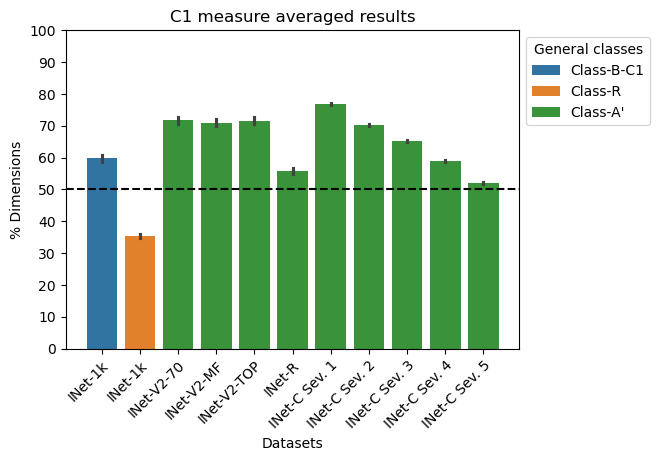

In [47]:
## ----- overall C1 measure result plot ----- ##

fig, ax = plt.subplots(figsize=a_5_size)
df_basic_i_c = dfs_basic['count_dims_nearer'].loc[dfs_basic['count_dims_nearer']['dset']=='inet_c']
sns_plot = sns.barplot(ax=ax, data=dfs_basic['count_dims_nearer'], x='dset', y='dim_rel', hue='Split')
loc, labels = plt.xticks()
x_labels_mapping(labels)
plt.xticks(loc, labels)
handles, labels = sns_plot.get_legend_handles_labels()
sns_plot.legend(handles, ['Class-B-C1', 'Class-R', 'Class-A\''], title='General classes')
sns_plot.set(xlabel='Datasets', ylabel='% Dimensions')
sns.move_legend(sns_plot, 'upper left', bbox_to_anchor=(1,1))
plt.xticks(rotation=45, rotation_mode='anchor', ha='right')
plt.ylim((0, 100))
plt.axhline(y=50, color='black', linestyle='--')
sns_plot.set_yticks(np.arange(0, 101, 10))
plt.title('C1 measure averaged results')
plt.plot()
plt.savefig(f'{save_dir}/overall_c1.png', bbox_inches='tight')
plt.show()
